In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import PowerTransformer, StandardScaler, MinMaxScaler, normalize
from sklearn.metrics import silhouette_score
from sklearn.cluster import SpectralClustering 
from kmodes.kprototypes import KPrototypes
from sklearn.mixture import GaussianMixture
import umap.umap_ as umap
from lightgbm import LGBMClassifier
import shap

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

import warnings
warnings.filterwarnings("ignore") 
%matplotlib inline

pd.set_option('display.max_columns', None)

RuntimeError: module compiled against API version 0xe but this version of numpy is 0xd

In [3]:
data = pd.read_excel (r'C:\Users\AtulPoddar\OneDrive - TheMathCompany Private Limited\Documents\Aspen Dental\Clustering\20210604 - Yield Analysis Clustering - Office Details (April, 2021).xlsx', engine = 'openpyxl')
data.columns

Index(['FacilityCode', 'Facility Name', 'Office Status', 'Sqft', 'Open Date',
       'Current Working Year', 'NPA Benchmarks', 'TotalRevenue', 'EBITDA',
       'TotalRevenuePerHour', 'EBITDAPerHour', 'Exclude Data', 'NPRevenue',
       'Primary Lender', 'Primary Chair', 'Secondary Chair', 'Total Employee',
       'Clinic', 'Technicians', 'Services', '% AfricanAmerican', '% Hispanic',
       '% Uninsured', 'Median Normalised Income', 'Ext Comp Within 20 Miles',
       'Aspen Within 20 Miles', 'Clusters', 'Office Class', 'POP Owner',
       'CVS Walgreens (.25mi)', 'Fast Cas. Mexican Burger (.25mi)',
       'Shop. Center GLA (1.5mi)', 'Big Box Retailers (1.5mi)',
       'Highway Exit (.5mi)\n1=Yes, 0=No', 'Housing Value Ratio (1/15mi)',
       'High School Graduates (5-7-10mi)', 'Employees (3mi)',
       '% HH Income $200K+ (5mi)', '% Veterans (20mi)',
       '% Speaking Only English (20mi)', 'Median Age (20mi)',
       '% Rural Industries (10mi)', '% High School or Less (15mi)',
       

In [4]:
data.drop_duplicates(subset=['FacilityCode'], inplace=True, ignore_index=True)

data.drop(['NPS', 'NP Yes Today','Facility Name', 'Office Status','Open Date','TotalRevenue', 'EBITDA', 'Primary Lender',
           'POP Owner','Exclude Data','NPRevenue', 'High School Graduates (5-7-10mi)', '% Black (10mi)'], axis=1, inplace=True)

data.rename({"Highway Exit (.5mi)\n1=Yes, 0=No" : "Highway Exit (.5mi)"}, axis=1, inplace=True)

In [5]:
data['Sqft'].fillna(data['Sqft'].median(), inplace=True)
data.dropna(inplace=True)
data.reset_index(drop=True, inplace=True)

In [6]:
model_cols = ['Office Class', 'Sqft', 'Current Working Year', 'NPA Benchmarks', 'Primary Chair', 'Secondary Chair',
              'Total Employee', 'Clinic', 'Technicians', 'Services', 'Median Normalised Income', 'Ext Comp Within 20 Miles',
              'Aspen Within 20 Miles', 'CVS Walgreens (.25mi)', 'Fast Cas. Mexican Burger (.25mi)',
              'Shop. Center GLA (1.5mi)', 'Big Box Retailers (1.5mi)', 'Highway Exit (.5mi)', 'Housing Value Ratio (1/15mi)',
              'Employees (3mi)', 'Dental Chains (1mi)', 'Delta Dental per 10K (10mi)', 'Years in DMA', 'Median Age (20mi)', 
              '% HH Income $200K+ (5mi)', '% Veterans (20mi)', '% Speaking Only English (20mi)', '% Rural Industries (10mi)',
              '% High School or Less (15mi)', '% No Health Insur. (10mi)', '% Medicaid (10mi)',
              '% AfricanAmerican', '% Hispanic', '% Uninsured']

rem_cols = ['FacilityCode', 'Clusters', 'TotalRevenuePerHour', 'EBITDAPerHour']

In [7]:
# Capping att 99-percentile
outlier_cols = ['Sqft', 'Median Normalised Income', 'Ext Comp Within 20 Miles', 'Shop. Center GLA (1.5mi)', 'Employees (3mi)']

data[outlier_cols] = np.where(data[outlier_cols]>data[outlier_cols].quantile(0.99),
                         data[outlier_cols].quantile(0.99),
                         data[outlier_cols])

In [8]:
data

,FacilityCode,Sqft,Current Working Year,NPA Benchmarks,TotalRevenuePerHour,EBITDAPerHour,Primary Chair,Secondary Chair,Total Employee,Clinic,Technicians,Services,% AfricanAmerican,% Hispanic,% Uninsured,Median Normalised Income,Ext Comp Within 20 Miles,Aspen Within 20 Miles,Clusters,Office Class,CVS Walgreens (.25mi),Fast Cas. Mexican Burger (.25mi),Shop. Center GLA (1.5mi),Big Box Retailers (1.5mi),Highway Exit (.5mi),Housing Value Ratio (1/15mi),Employees (3mi),% HH Income $200K+ (5mi),% Veterans (20mi),% Speaking Only English (20mi),Median Age (20mi),% Rural Industries (10mi),% High School or Less (15mi),% No Health Insur. (10mi),% Medicaid (10mi),Dental Chains (1mi),Delta Dental per 10K (10mi),Years in DMA
0,5.0,3750.0,22.0,7.677060,310.106528,43.916479,4.0,1.0,7.0,5.0,1.0,1.0,0.148,0.199,0.0499,76467.6400,463.0,6.0,High Competition,Suburban,0.0,0.0,1781005.0,1.0,1.0,0.9,43876.0,0.0544,0.0604,0.7682,41.8,0.0520,0.3851,0.0499,0.2192,0.0,3.8,31.0
1,19.0,4000.0,22.0,7.547576,388.106691,79.871863,4.0,1.0,11.0,7.0,2.0,2.0,0.068,0.179,0.0583,66714.4800,293.0,6.0,Low uninsured,Suburban,0.0,0.0,895999.0,3.0,1.0,1.3,23603.0,0.0552,0.0672,0.7789,41.4,0.0524,0.4348,0.0583,0.2221,0.0,1.9,31.0
2,21.0,3952.0,22.0,6.762903,403.084125,83.551933,5.0,1.0,15.0,11.0,1.0,3.0,0.022,0.043,0.0302,72641.3700,289.0,7.0,Low uninsured,Urban,2.0,0.0,934543.0,0.0,1.0,0.9,29231.0,0.0169,0.0656,0.7494,40.8,0.0734,0.4447,0.0302,0.2179,1.0,2.5,31.0
3,30.0,3687.0,22.0,5.142188,309.008400,54.973818,5.0,1.0,10.0,7.0,1.0,2.0,0.145,0.192,0.0791,93421.4000,452.0,3.0,High Median Income,Most Urban,1.0,0.0,0.0,0.0,0.0,1.4,38940.0,0.0968,0.0469,0.7265,40.8,0.0623,0.3308,0.0791,0.1946,0.0,3.8,31.0
4,41.0,3138.0,19.0,4.625620,384.471168,81.514455,5.0,1.0,7.0,4.0,1.0,2.0,0.066,0.141,0.0837,108614.1072,471.0,2.0,High Median Income,Suburban,0.0,0.0,0.0,0.0,0.0,1.1,31080.0,0.1829,0.0451,0.7149,42.2,0.0586,0.3024,0.0837,0.0991,0.0,4.1,31.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
872,9436.0,3202.0,10.0,8.599539,374.210614,82.902711,5.0,1.0,13.0,9.0,1.0,3.0,0.096,0.140,0.0638,79625.1600,200.0,3.0,Moderate Income,Rural,0.0,0.0,737834.0,1.0,0.0,1.3,16950.0,0.0287,0.0755,0.7923,37.8,0.0581,0.4125,0.0638,0.1761,1.0,1.6,12.0
873,9440.0,3200.0,10.0,7.355985,247.984233,42.685276,4.0,1.0,10.0,6.0,1.0,3.0,0.086,0.035,0.0724,78995.1600,125.0,1.0,High Uninsured,Rural,0.0,0.0,182298.0,0.0,1.0,1.1,7809.0,0.0115,0.0723,0.9012,37.7,0.0917,0.4213,0.0724,0.1740,0.0,3.9,11.0
874,9451.0,3350.0,10.0,6.684684,334.662032,72.323895,6.0,1.0,17.0,12.0,1.0,4.0,0.064,0.379,0.1516,61606.4800,1117.8,8.0,Low Median Income,Most Urban,0.0,2.0,1179789.0,2.0,0.0,1.3,103562.0,0.0577,0.0711,0.7075,36.3,0.0747,0.3816,0.1516,0.2367,1.0,3.2,13.0
875,9465.0,3300.0,10.0,10.353428,277.260434,59.142727,5.0,1.0,14.0,6.0,1.0,7.0,0.122,0.149,0.0676,71393.4000,138.0,3.0,Moderate Income,Suburban,1.0,0.0,1468969.0,1.0,0.0,1.1,28178.0,0.0171,0.0812,0.8715,40.4,0.0561,0.4078,0.0676,0.2012,0.0,2.0,12.0


In [9]:
datawithoutcat = data.copy()

In [10]:
datawithoutcat

,FacilityCode,Sqft,Current Working Year,NPA Benchmarks,TotalRevenuePerHour,EBITDAPerHour,Primary Chair,Secondary Chair,Total Employee,Clinic,Technicians,Services,% AfricanAmerican,% Hispanic,% Uninsured,Median Normalised Income,Ext Comp Within 20 Miles,Aspen Within 20 Miles,Clusters,Office Class,CVS Walgreens (.25mi),Fast Cas. Mexican Burger (.25mi),Shop. Center GLA (1.5mi),Big Box Retailers (1.5mi),Highway Exit (.5mi),Housing Value Ratio (1/15mi),Employees (3mi),% HH Income $200K+ (5mi),% Veterans (20mi),% Speaking Only English (20mi),Median Age (20mi),% Rural Industries (10mi),% High School or Less (15mi),% No Health Insur. (10mi),% Medicaid (10mi),Dental Chains (1mi),Delta Dental per 10K (10mi),Years in DMA
0,5.0,3750.0,22.0,7.677060,310.106528,43.916479,4.0,1.0,7.0,5.0,1.0,1.0,0.148,0.199,0.0499,76467.6400,463.0,6.0,High Competition,Suburban,0.0,0.0,1781005.0,1.0,1.0,0.9,43876.0,0.0544,0.0604,0.7682,41.8,0.0520,0.3851,0.0499,0.2192,0.0,3.8,31.0
1,19.0,4000.0,22.0,7.547576,388.106691,79.871863,4.0,1.0,11.0,7.0,2.0,2.0,0.068,0.179,0.0583,66714.4800,293.0,6.0,Low uninsured,Suburban,0.0,0.0,895999.0,3.0,1.0,1.3,23603.0,0.0552,0.0672,0.7789,41.4,0.0524,0.4348,0.0583,0.2221,0.0,1.9,31.0
2,21.0,3952.0,22.0,6.762903,403.084125,83.551933,5.0,1.0,15.0,11.0,1.0,3.0,0.022,0.043,0.0302,72641.3700,289.0,7.0,Low uninsured,Urban,2.0,0.0,934543.0,0.0,1.0,0.9,29231.0,0.0169,0.0656,0.7494,40.8,0.0734,0.4447,0.0302,0.2179,1.0,2.5,31.0
3,30.0,3687.0,22.0,5.142188,309.008400,54.973818,5.0,1.0,10.0,7.0,1.0,2.0,0.145,0.192,0.0791,93421.4000,452.0,3.0,High Median Income,Most Urban,1.0,0.0,0.0,0.0,0.0,1.4,38940.0,0.0968,0.0469,0.7265,40.8,0.0623,0.3308,0.0791,0.1946,0.0,3.8,31.0
4,41.0,3138.0,19.0,4.625620,384.471168,81.514455,5.0,1.0,7.0,4.0,1.0,2.0,0.066,0.141,0.0837,108614.1072,471.0,2.0,High Median Income,Suburban,0.0,0.0,0.0,0.0,0.0,1.1,31080.0,0.1829,0.0451,0.7149,42.2,0.0586,0.3024,0.0837,0.0991,0.0,4.1,31.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
872,9436.0,3202.0,10.0,8.599539,374.210614,82.902711,5.0,1.0,13.0,9.0,1.0,3.0,0.096,0.140,0.0638,79625.1600,200.0,3.0,Moderate Income,Rural,0.0,0.0,737834.0,1.0,0.0,1.3,16950.0,0.0287,0.0755,0.7923,37.8,0.0581,0.4125,0.0638,0.1761,1.0,1.6,12.0
873,9440.0,3200.0,10.0,7.355985,247.984233,42.685276,4.0,1.0,10.0,6.0,1.0,3.0,0.086,0.035,0.0724,78995.1600,125.0,1.0,High Uninsured,Rural,0.0,0.0,182298.0,0.0,1.0,1.1,7809.0,0.0115,0.0723,0.9012,37.7,0.0917,0.4213,0.0724,0.1740,0.0,3.9,11.0
874,9451.0,3350.0,10.0,6.684684,334.662032,72.323895,6.0,1.0,17.0,12.0,1.0,4.0,0.064,0.379,0.1516,61606.4800,1117.8,8.0,Low Median Income,Most Urban,0.0,2.0,1179789.0,2.0,0.0,1.3,103562.0,0.0577,0.0711,0.7075,36.3,0.0747,0.3816,0.1516,0.2367,1.0,3.2,13.0
875,9465.0,3300.0,10.0,10.353428,277.260434,59.142727,5.0,1.0,14.0,6.0,1.0,7.0,0.122,0.149,0.0676,71393.4000,138.0,3.0,Moderate Income,Suburban,1.0,0.0,1468969.0,1.0,0.0,1.1,28178.0,0.0171,0.0812,0.8715,40.4,0.0561,0.4078,0.0676,0.2012,0.0,2.0,12.0


In [11]:
datawithoutcat.drop(['Office Class','Clusters'], axis=1, inplace=True)

In [14]:
datawithoutcat.drop(['FacilityCode','TotalRevenuePerHour', 'EBITDAPerHour'], axis=1, inplace=True)

In [15]:
datawithoutcat

,Sqft,Current Working Year,NPA Benchmarks,Primary Chair,Secondary Chair,Total Employee,Clinic,Technicians,Services,% AfricanAmerican,% Hispanic,% Uninsured,Median Normalised Income,Ext Comp Within 20 Miles,Aspen Within 20 Miles,CVS Walgreens (.25mi),Fast Cas. Mexican Burger (.25mi),Shop. Center GLA (1.5mi),Big Box Retailers (1.5mi),Highway Exit (.5mi),Housing Value Ratio (1/15mi),Employees (3mi),% HH Income $200K+ (5mi),% Veterans (20mi),% Speaking Only English (20mi),Median Age (20mi),% Rural Industries (10mi),% High School or Less (15mi),% No Health Insur. (10mi),% Medicaid (10mi),Dental Chains (1mi),Delta Dental per 10K (10mi),Years in DMA
0,3750.0,22.0,7.677060,4.0,1.0,7.0,5.0,1.0,1.0,0.148,0.199,0.0499,76467.6400,463.0,6.0,0.0,0.0,1781005.0,1.0,1.0,0.9,43876.0,0.0544,0.0604,0.7682,41.8,0.0520,0.3851,0.0499,0.2192,0.0,3.8,31.0
1,4000.0,22.0,7.547576,4.0,1.0,11.0,7.0,2.0,2.0,0.068,0.179,0.0583,66714.4800,293.0,6.0,0.0,0.0,895999.0,3.0,1.0,1.3,23603.0,0.0552,0.0672,0.7789,41.4,0.0524,0.4348,0.0583,0.2221,0.0,1.9,31.0
2,3952.0,22.0,6.762903,5.0,1.0,15.0,11.0,1.0,3.0,0.022,0.043,0.0302,72641.3700,289.0,7.0,2.0,0.0,934543.0,0.0,1.0,0.9,29231.0,0.0169,0.0656,0.7494,40.8,0.0734,0.4447,0.0302,0.2179,1.0,2.5,31.0
3,3687.0,22.0,5.142188,5.0,1.0,10.0,7.0,1.0,2.0,0.145,0.192,0.0791,93421.4000,452.0,3.0,1.0,0.0,0.0,0.0,0.0,1.4,38940.0,0.0968,0.0469,0.7265,40.8,0.0623,0.3308,0.0791,0.1946,0.0,3.8,31.0
4,3138.0,19.0,4.625620,5.0,1.0,7.0,4.0,1.0,2.0,0.066,0.141,0.0837,108614.1072,471.0,2.0,0.0,0.0,0.0,0.0,0.0,1.1,31080.0,0.1829,0.0451,0.7149,42.2,0.0586,0.3024,0.0837,0.0991,0.0,4.1,31.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
872,3202.0,10.0,8.599539,5.0,1.0,13.0,9.0,1.0,3.0,0.096,0.140,0.0638,79625.1600,200.0,3.0,0.0,0.0,737834.0,1.0,0.0,1.3,16950.0,0.0287,0.0755,0.7923,37.8,0.0581,0.4125,0.0638,0.1761,1.0,1.6,12.0
873,3200.0,10.0,7.355985,4.0,1.0,10.0,6.0,1.0,3.0,0.086,0.035,0.0724,78995.1600,125.0,1.0,0.0,0.0,182298.0,0.0,1.0,1.1,7809.0,0.0115,0.0723,0.9012,37.7,0.0917,0.4213,0.0724,0.1740,0.0,3.9,11.0
874,3350.0,10.0,6.684684,6.0,1.0,17.0,12.0,1.0,4.0,0.064,0.379,0.1516,61606.4800,1117.8,8.0,0.0,2.0,1179789.0,2.0,0.0,1.3,103562.0,0.0577,0.0711,0.7075,36.3,0.0747,0.3816,0.1516,0.2367,1.0,3.2,13.0
875,3300.0,10.0,10.353428,5.0,1.0,14.0,6.0,1.0,7.0,0.122,0.149,0.0676,71393.4000,138.0,3.0,1.0,0.0,1468969.0,1.0,0.0,1.1,28178.0,0.0171,0.0812,0.8715,40.4,0.0561,0.4078,0.0676,0.2012,0.0,2.0,12.0


In [13]:
pt = PowerTransformer()
cols = data[model_cols].select_dtypes(exclude='object').columns

df_scaled = data[model_cols].copy()
df_scaled[cols] = pt.fit_transform(df_scaled[cols])
df_scaled.head()

,Office Class,Sqft,Current Working Year,NPA Benchmarks,Primary Chair,Secondary Chair,Total Employee,Clinic,Technicians,Services,Median Normalised Income,Ext Comp Within 20 Miles,Aspen Within 20 Miles,CVS Walgreens (.25mi),Fast Cas. Mexican Burger (.25mi),Shop. Center GLA (1.5mi),Big Box Retailers (1.5mi),Highway Exit (.5mi),Housing Value Ratio (1/15mi),Employees (3mi),Dental Chains (1mi),Delta Dental per 10K (10mi),Years in DMA,Median Age (20mi),% HH Income $200K+ (5mi),% Veterans (20mi),% Speaking Only English (20mi),% Rural Industries (10mi),% High School or Less (15mi),% No Health Insur. (10mi),% Medicaid (10mi),% AfricanAmerican,% Hispanic,% Uninsured
0,Suburban,0.900078,2.018926,-0.670438,-1.071551,0.0,-1.883222,-1.038058,-0.469686,-2.611871,0.396025,1.181009,1.430220,-0.518812,-0.797541,0.985737,-0.398544,1.287469,-0.243519,0.940047,-0.660735,0.912377,2.24011,0.622546,1.334326,-1.220192,-1.294187,-1.065349,-0.136832,-1.008033,0.925782,0.632813,1.390337,-1.008033
1,Suburban,1.622680,2.018926,-0.732438,-1.071551,0.0,-0.273053,-0.088250,1.086638,-1.349993,-0.385459,0.761589,1.430220,-0.518812,-0.797541,0.109144,1.401311,1.287469,1.241189,0.035700,-0.660735,-1.117743,2.24011,0.520969,1.357907,-0.792950,-1.222092,-1.037010,0.516025,-0.720190,0.972804,-0.289735,1.267809,-0.720190
2,Urban,1.490526,2.018926,-1.115853,0.093686,0.0,0.990808,1.467175,-0.469686,-0.270924,0.106121,0.749169,1.592124,1.959789,-0.797541,0.155928,-1.613483,1.287469,-0.243519,0.342492,1.456531,-0.426547,2.24011,0.363391,-0.804382,-0.889455,-1.408465,0.187575,0.641206,-1.759870,0.904582,-1.097365,-0.582897,-1.759870
3,Most Urban,0.703675,2.018926,-1.956509,0.093686,0.0,-0.634849,-0.088250,-0.469686,-1.349993,1.481353,1.158677,0.727433,1.922152,-0.797541,-2.507847,-1.613483,-0.776718,1.545675,0.762396,-0.660735,0.912377,2.24011,0.363391,2.041884,-2.215595,-1.528598,-0.399632,-0.900393,-0.080773,0.511413,0.606227,1.349923,-0.080773
4,Suburban,-1.314892,1.715087,-2.241154,0.093686,0.0,-1.883222,-1.581794,-0.469686,-1.349993,2.252205,1.196939,0.350387,-0.518812,-0.797541,-2.507847,-1.613483,-0.776718,0.559032,0.431471,-0.660735,1.197727,2.24011,0.721458,2.299476,-2.365021,-1.582340,-0.624062,-1.322649,0.047804,-1.403941,-0.319733,0.963749,0.047804


In [23]:
df_scaled_nocat = df_scaled.copy()
df_scaled_nocat.drop(['Office Class'], axis=1, inplace=True)

In [24]:
df_scaled_nocat

,Sqft,Current Working Year,NPA Benchmarks,Primary Chair,Secondary Chair,Total Employee,Clinic,Technicians,Services,Median Normalised Income,Ext Comp Within 20 Miles,Aspen Within 20 Miles,CVS Walgreens (.25mi),Fast Cas. Mexican Burger (.25mi),Shop. Center GLA (1.5mi),Big Box Retailers (1.5mi),Highway Exit (.5mi),Housing Value Ratio (1/15mi),Employees (3mi),Dental Chains (1mi),Delta Dental per 10K (10mi),Years in DMA,Median Age (20mi),% HH Income $200K+ (5mi),% Veterans (20mi),% Speaking Only English (20mi),% Rural Industries (10mi),% High School or Less (15mi),% No Health Insur. (10mi),% Medicaid (10mi),% AfricanAmerican,% Hispanic,% Uninsured
0,0.900078,2.018926,-0.670438,-1.071551,0.0,-1.883222,-1.038058,-0.469686,-2.611871,0.396025,1.181009,1.430220,-0.518812,-0.797541,0.985737,-0.398544,1.287469,-0.243519,0.940047,-0.660735,0.912377,2.240110,0.622546,1.334326,-1.220192,-1.294187,-1.065349,-0.136832,-1.008033,0.925782,0.632813,1.390337,-1.008033
1,1.622680,2.018926,-0.732438,-1.071551,0.0,-0.273053,-0.088250,1.086638,-1.349993,-0.385459,0.761589,1.430220,-0.518812,-0.797541,0.109144,1.401311,1.287469,1.241189,0.035700,-0.660735,-1.117743,2.240110,0.520969,1.357907,-0.792950,-1.222092,-1.037010,0.516025,-0.720190,0.972804,-0.289735,1.267809,-0.720190
2,1.490526,2.018926,-1.115853,0.093686,0.0,0.990808,1.467175,-0.469686,-0.270924,0.106121,0.749169,1.592124,1.959789,-0.797541,0.155928,-1.613483,1.287469,-0.243519,0.342492,1.456531,-0.426547,2.240110,0.363391,-0.804382,-0.889455,-1.408465,0.187575,0.641206,-1.759870,0.904582,-1.097365,-0.582897,-1.759870
3,0.703675,2.018926,-1.956509,0.093686,0.0,-0.634849,-0.088250,-0.469686,-1.349993,1.481353,1.158677,0.727433,1.922152,-0.797541,-2.507847,-1.613483,-0.776718,1.545675,0.762396,-0.660735,0.912377,2.240110,0.363391,2.041884,-2.215595,-1.528598,-0.399632,-0.900393,-0.080773,0.511413,0.606227,1.349923,-0.080773
4,-1.314892,1.715087,-2.241154,0.093686,0.0,-1.883222,-1.581794,-0.469686,-1.349993,2.252205,1.196939,0.350387,-0.518812,-0.797541,-2.507847,-1.613483,-0.776718,0.559032,0.431471,-0.660735,1.197727,2.240110,0.721458,2.299476,-2.365021,-1.582340,-0.624062,-1.322649,0.047804,-1.403941,-0.319733,0.963749,0.047804
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
872,-1.046605,0.549961,-0.238180,0.093686,0.0,0.390943,0.734038,-0.469686,-0.270924,0.621116,0.420464,0.727433,-0.518812,-0.797541,-0.096214,-0.398544,-0.776718,1.241189,-0.428873,1.456531,-1.486791,0.237563,-0.530946,0.155695,-0.328912,-1.123896,-0.655604,0.228238,-0.541348,0.180487,0.090072,0.954217,-0.541348
873,-1.054838,0.549961,-0.824815,-1.071551,0.0,-0.634849,-0.543784,-0.469686,-0.270924,0.577162,0.011724,-0.199984,-0.518812,-0.797541,-1.169780,-1.613483,1.287469,0.559032,-1.468473,-0.660735,1.008338,0.089006,-0.564192,-1.380955,-0.500815,0.111404,0.927235,0.342781,-0.276037,0.141816,-0.037400,-0.788705,-0.276037
874,-0.462711,0.549961,-1.154839,1.084489,0.0,1.539714,1.807696,-0.469686,0.689830,-0.858137,2.022149,1.733131,-0.518812,1.511575,0.430253,0.567752,-0.776718,1.241189,2.270631,1.456531,0.317174,0.378967,-1.056542,1.427937,-0.567496,-1.614348,0.248746,-0.184408,1.523531,1.203969,-0.350146,1.905319,1.523531
875,-0.654536,0.549961,0.543620,0.093686,0.0,0.697957,-0.543784,-0.469686,3.136312,0.007145,0.096742,0.727433,1.922152,-0.797541,0.713982,-0.398544,-0.776718,0.559032,0.289479,-0.660735,-0.998479,0.237563,0.254713,-0.784897,-0.042883,-0.318542,-0.784787,0.166531,-0.422017,0.625375,0.384421,1.036890,-0.422017


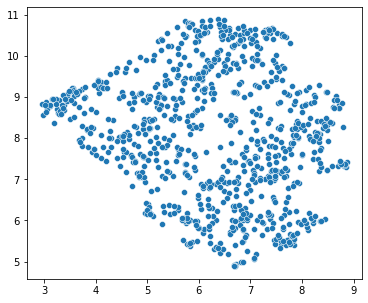

In [185]:
embedding_scaled = umap.UMAP(n_neighbors=20, random_state=42, min_dist=.01, metric='euclidean', target_n_neighbors=5, n_epochs=500).fit_transform(df_scaled.select_dtypes(exclude='object'))

plt.figure(figsize=(6,5))
sns.scatterplot(embedding_scaled[:, 0], embedding_scaled[:, 1], palette='Dark2')

# tsne = TSNE(random_state = 42, n_components=3,verbose=0, perplexity=20, n_iter=400).fit_transform(df_scaled.select_dtypes(exclude='object'))
# sns.scatterplot(tsne[:, 0], tsne[:, 1], palette='Dark2')

# GMM

In [210]:
gmm = GaussianMixture(n_components=5, max_iter=1500).fit(df_scaled_nocat)
labels1 = gmm.predict(df_scaled_nocat)

In [211]:
gmm_clusters1 = data.copy()
gmm_clusters1['Cluster_ID'] = labels1
gmm_clusters1['Cluster_ID'].value_counts()

1    207
2    195
4    192
3    163
0    120
Name: Cluster_ID, dtype: int64

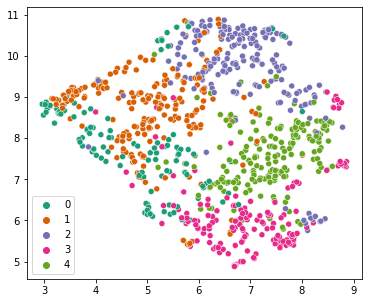

In [212]:
plt.figure(figsize=(6,5))
sns.scatterplot(embedding_scaled[:, 0], embedding_scaled[:, 1], hue=labels1, palette='Dark2')

In [213]:
#Setting the objects to category 
lgbm_data = data[model_cols].copy()
for c in lgbm_data.select_dtypes(include='object'):
    lgbm_data[c] = lgbm_data[c].astype('category')

In [214]:
from sklearn.model_selection import cross_val_score

In [215]:
clf_kp = LGBMClassifier(colsample_by_tree=0.8)
cv_scores_kp = cross_val_score(clf_kp, lgbm_data, labels1, cv=5, scoring='f1_weighted')
print(f'CV F1 score for K-Prototypes clusters is {np.mean(cv_scores_kp)}')

[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
CV F1 score for K-Prototypes clusters is 0.8116525806897681


In [216]:
clf_kp.fit(lgbm_data, labels1)

[LightGBM] [Warning] Unknown parameter: colsample_by_tree


LGBMClassifier(colsample_by_tree=0.8)

In [217]:
explainer_kp = shap.TreeExplainer(clf_kp)
shap_values_kp = explainer_kp.shap_values(lgbm_data)

C extension was not built during install!


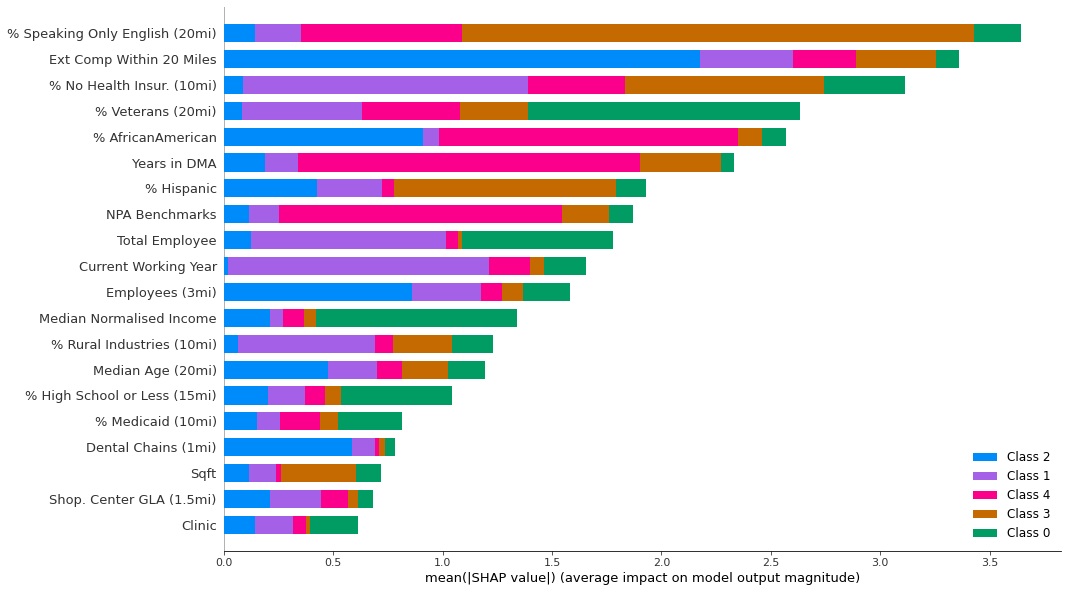

In [218]:
shap.summary_plot(shap_values_kp, lgbm_data, plot_type="bar", plot_size=(15, 10))

In [219]:
df_scaled_clusters = data[model_cols].copy()
df_scaled_clusters['Cluster_ID'] = labels1
df_scaled_clusters = pd.concat([df_scaled_clusters, data[rem_cols]], axis = 1)
df_scaled_clusters['Cluster_ID'].value_counts()

1    207
2    195
4    192
3    163
0    120
Name: Cluster_ID, dtype: int64

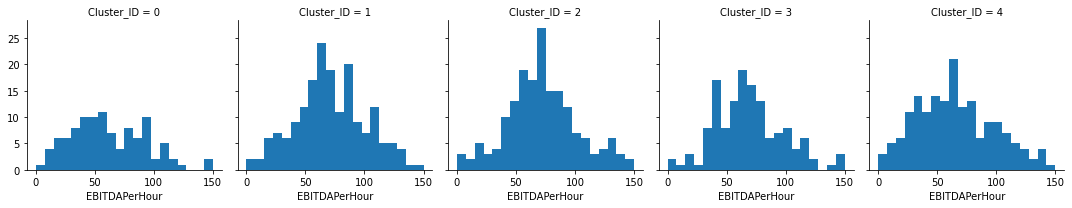

In [220]:
grid = sns.FacetGrid(df_scaled_clusters, col='Cluster_ID')
grid.map(plt.hist, 'EBITDAPerHour', range=[0,150], bins=20)

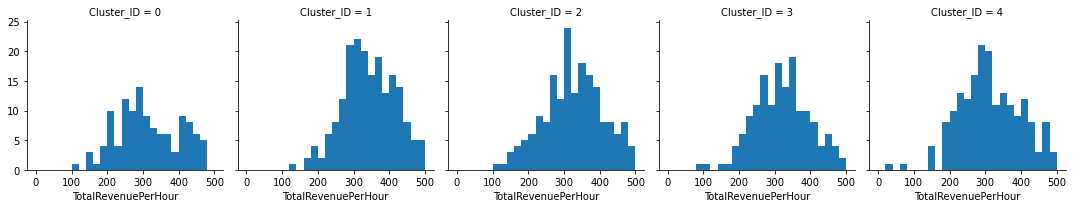

In [221]:
grid = sns.FacetGrid(df_scaled_clusters, col='Cluster_ID')
grid.map(plt.hist, 'TotalRevenuePerHour', range=[0,500], bins=25)

In [223]:
df_scaled_clusters.groupby('Cluster_ID').agg(
    {
        'EBITDAPerHour' : ['min', 'max', 'median', 'mean'],
        'TotalRevenuePerHour' : ['min', 'max', 'median', 'mean']
    }
).reset_index().round(2)

Cluster_ID EBITDAPerHour                       TotalRevenuePerHour          \
                       min     max median   mean                 min     max   
0          0       -132.23  581.12  54.64  59.14              110.11  536.81   
1          1      -2797.22  303.34  73.37  59.56              121.80  786.32   
2          2       -139.91  183.53  70.59  66.57              118.17  641.33   
3          3       -117.10  202.18  62.70  59.69               87.92  571.81   
4          4      -3826.76  267.89  60.80  41.73               23.43  619.42   

                   
   median    mean  
0  301.76  317.38  
1  346.31  357.91  
2  330.62  338.40  
3  322.11  328.94  
4  308.06  322.91